In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.dates as mdates
import os

In [2]:
df = pd.read_excel('Logistic_data.xlsx')

In [3]:
target_col = "Крепкое спиртное (от 40') - А"

In [4]:
df['Месяц/год'] = pd.to_datetime(df['Месяц/год'], errors='coerce')
df = df.dropna(subset=['Месяц/год'])
df = df.set_index('Месяц/год')

In [5]:
df['month_num'] = ((df.index.year - df.index.year.min()) * 12 + df.index.month)

In [6]:
col = "Крепкое спиртное (от 40') - А"
x_numeric = mdates.date2num(df.index.to_pydatetime())
y_values = df[col].values
coeffs = np.polyfit(x_numeric, y_values, deg=1)
trend_fn = np.poly1d(coeffs)
x_fit = np.linspace(x_numeric.min(), x_numeric.max(), 100)
y_fit = trend_fn(x_fit)
dates_fit = mdates.num2date(x_fit)

In [7]:
month_series = df.index.month

df_dummies = pd.get_dummies(month_series, prefix='month', drop_first=False)
df_dummies.index = df.index
df_model = pd.concat([df, df_dummies], axis=1)

predictors = ['month_num'] + list(df_dummies.columns)

X = df_model[predictors]
y = df_model[target_col]
X = sm.add_constant(X)


In [8]:
cutoff_date = pd.Timestamp('2009-07-01')
X_train = X.loc[df_model.index < cutoff_date]
y_train = y.loc[df_model.index < cutoff_date]
for col in X_train.select_dtypes(include='bool').columns:
    X_train[col] = X_train[col].astype('int32')

In [9]:
model = sm.OLS(y_train, X_train).fit()

In [10]:
future_dates = pd.date_range(start='2009-07-01', end='2010-07-01', freq='MS')
future_df = pd.DataFrame(index=future_dates)

In [11]:
future_df['month_num'] = ((future_df.index.year - df.index.year.min()) * 12  + future_df.index.month - 7)
month_series_future = pd.Series(future_df.index.month, index=future_df.index)
future_dummies = pd.get_dummies(month_series_future, prefix='month', drop_first=True)


In [12]:
future_df = pd.concat([future_df, future_dummies], axis=1)

In [13]:
for col in df_dummies.columns:
    if col not in future_df.columns:
        future_df[col] = 0

In [14]:
X_future = future_df[['month_num'] + list(df_dummies.columns)]
X_future = sm.add_constant(X_future)
future_df['Predicted'] = np.ceil(model.predict(X_future))

In [15]:
all_dates = list(df_model.index) + list(future_df.index)
all_dates = pd.to_datetime(all_dates)
all_x = mdates.date2num(all_dates)
all_y = np.concatenate([y.values, future_df['Predicted'].values]).astype('int32')

In [16]:
coeffs_all = np.polyfit(all_x, all_y, deg=1)
trend_fn_all = np.poly1d(coeffs_all)
x_fit_all = np.linspace(all_x.min(), all_x.max(), 100)
y_fit_all = trend_fn_all(x_fit_all)
dates_fit_all = mdates.num2date(x_fit_all)


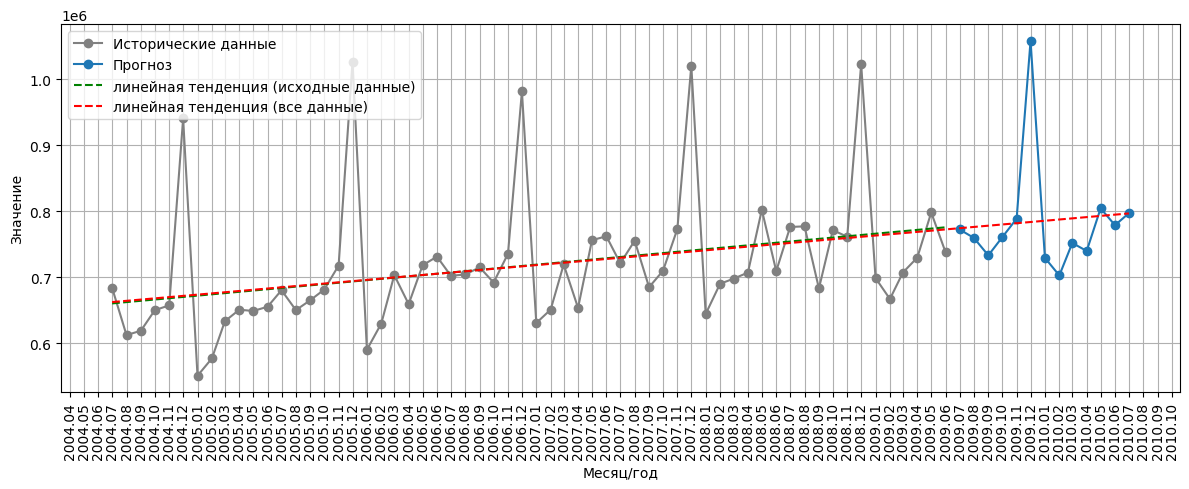

In [17]:

plt.figure(figsize=(12, 5))
plt.plot(df_model.index, y, label='Исторические данные', marker='o', color='grey')
plt.plot(future_df.index, future_df['Predicted'], label='Прогноз', marker='o')
plt.plot(dates_fit, y_fit, label='линейная тенденция (исходные данные)', color='green', linestyle='--')
plt.plot(dates_fit_all, y_fit_all, label='линейная тенденция (все данные)', color='red', linestyle='--')

plt.xlabel('Месяц/год')
plt.ylabel('Значение')
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m'))
plt.xticks(rotation=90)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# 9. Сохранение результатов прогноза в Excel
output_filename = "forecast_results.xlsx"
future_df["Predicted"].to_excel(output_filename)
print(f"\nРезультаты прогноза сохранены в файле {os.path.abspath(output_filename)}")


Результаты прогноза сохранены в файле c:\Users\mrche\OneDrive\Рабочий стол\ГОВНО\HwLOGIsSTIC\forecast_results.xlsx
